<a href="https://colab.research.google.com/github/Reemaalt/Detection-of-Hallucination-in-Arabic/blob/main/EvaluationOutline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What they did in the Evaluation?
1️⃣ They gave the AI a question-answering test.

2️⃣ The AI generated multiple answers per question.

3️⃣ They tested different methods to measure uncertainty
( they compared their method against:  predictive entropy, length-normalised predictive entropy, p(True) ,  and lexical similarity)

4️⃣ Semantic entropy worked best! It correctly identified when an answer was wrong better than older methods.



In [3]:

# Install required package
!pip install rouge-score

import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.special import softmax
from rouge_score import rouge_scorer
from itertools import combinations

# Load the ROUGE-L labeled data output file
with open("labeled_data_rougel.json", "r", encoding="utf-8") as file:
    rouge_data = json.load(file)

# Load the Semantic Entropy JSON file
semantic_entropy_file = "/content/semantic_entropy_Llama3.1-8b_xquadAll_results (1).json"
with open(semantic_entropy_file, "r", encoding="utf-8") as file:
    entropy_data = json.load(file)

# Initialize ROUGE scorer for lexical similarity
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


In [ ]:

# Store AUROC inputs
labels = []  # Correct (1) or Incorrect (0)
semantic_entropy_scores = []  # Semantic entropy uncertainty
predictive_entropy_scores = []  # Predictive entropy uncertainty
lexical_similarity_scores = []  # Lexical similarity uncertainty
num_semantic_clusters = []  # Number of unique semantic clusters per question
normalized_entropy_scores = []  # Normalized entropy uncertainty
median_confidence_scores = []  # Median Confidence Analysis
rouge_threshold = 0.3  # Threshold for classifying correctness

# Process each question
for question_id, details in rouge_data.items():
  # neg_log_likelihoods --> used to measure the avg model uncertainty
    log_likelihoods = details.get("total_avg_neg_log_likelihoods_for_clusters", [])
    if not log_likelihoods:
        print(f"Warning: No log likelihoods found for question ID {question_id}. Skipping...")
        continue

    # Compute Predictive Entropy --> uesd to measure the total model uncertainty
    probabilities = softmax(-np.array(log_likelihoods))
    predictive_entropy = -np.sum(probabilities * np.log(probabilities))

    # Compute Normalized Entropy --> Adjusts entropy for sentence length.
    avg_length = np.mean([len(cluster["text"].split()) for sublist in details.get("clusters", []) for cluster in sublist])
    normalized_entropy = predictive_entropy / avg_length if avg_length > 0 else predictive_entropy  # Avoid division by zero

    # Extract Semantic Entropy --> Measures uncertainty using semantic clusters.
    semantic_entropy = entropy_data.get(question_id, {}).get("semantic_entropy", predictive_entropy)

    # Check if 'clusters' key exists in details
    #compute lexical similarity --> Measures how similar the generated answers are.
    if "clusters" in details:
        all_clusters = [answer for sublist in details["clusters"] for answer in sublist]
        generated_answers = [cluster["text"] for cluster in all_clusters]

        if len(generated_answers) > 1:
            rouge_similarities = [
                scorer.score(ans1, ans2)["rougeL"].fmeasure
                for ans1, ans2 in combinations(generated_answers, 2)
            ]
            lexical_similarity = np.mean(rouge_similarities) if rouge_similarities else 0.0
        else:
            lexical_similarity = 0.0

        # Count the number of unique semantic clusters --> Measures answer diversity (higher = more uncertainty).
        num_clusters = len(details["clusters"])

        # Compute Median Confidence Analysis --> Checks if model's confidence aligns with correctness.
        median_confidence = np.median([-nll for nll in log_likelihoods])

        # Assign labels based on the ROUGE-L threshold
        for cluster in all_clusters:
            answer_label = 1 if cluster.get("f1_score", 0) > rouge_threshold else 0
            labels.append(answer_label)
            semantic_entropy_scores.append(semantic_entropy)
            predictive_entropy_scores.append(predictive_entropy)
            lexical_similarity_scores.append(lexical_similarity)
            num_semantic_clusters.append(num_clusters)
            normalized_entropy_scores.append(normalized_entropy)
            median_confidence_scores.append(median_confidence)
    else:
        print(f"Warning: 'clusters' missing for question ID {question_id}. Skipping...")
        continue # Move to next question if 'clusters' is missing


    # Compute Median Confidence Analysis
    median_confidence = np.median([-nll for nll in log_likelihoods])

    # Assign labels based on the ROUGE-L threshold --> ( not correct, we should compare the SE threshold to rouge-L threshold)
    for cluster in all_clusters:
        answer_label = 1 if cluster.get("f1_score", 0) > rouge_threshold else 0
        labels.append(answer_label)
        semantic_entropy_scores.append(semantic_entropy)
        predictive_entropy_scores.append(predictive_entropy)
        lexical_similarity_scores.append(lexical_similarity)
        num_semantic_clusters.append(num_clusters)
        normalized_entropy_scores.append(normalized_entropy)
        median_confidence_scores.append(median_confidence)



## AUROC

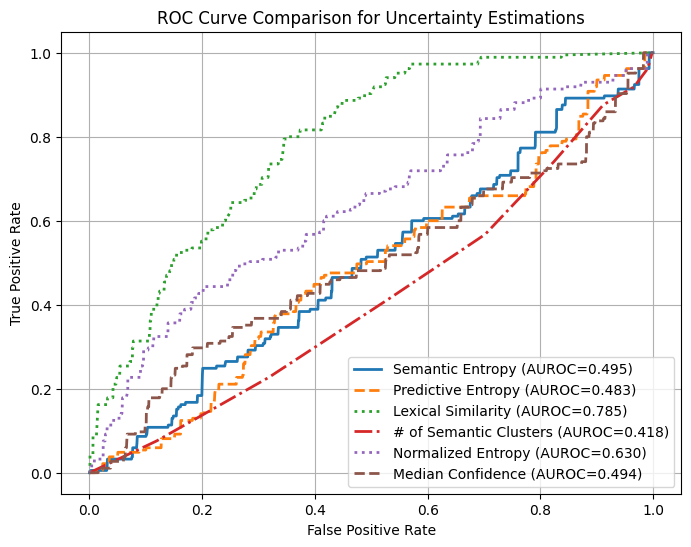

In [5]:
# Compute AUROC scores
if len(set(labels)) > 1:
    auroc_semantic_entropy = roc_auc_score(labels, semantic_entropy_scores)
    auroc_predictive_entropy = roc_auc_score(labels, predictive_entropy_scores)
    auroc_lexical_similarity = roc_auc_score(labels, lexical_similarity_scores)
    auroc_num_clusters = roc_auc_score(labels, num_semantic_clusters)
    auroc_normalized_entropy = roc_auc_score(labels, normalized_entropy_scores)
    auroc_median_confidence = roc_auc_score(labels, median_confidence_scores)
else:
    auroc_semantic_entropy = auroc_predictive_entropy = auroc_lexical_similarity = auroc_num_clusters = auroc_normalized_entropy = auroc_median_confidence = 0.0
    print("Warning: Not enough variation in labels to compute AUROC.")

# Compute ROC curves
fpr_semantic, tpr_semantic, _ = roc_curve(labels, semantic_entropy_scores)
fpr_predictive, tpr_predictive, _ = roc_curve(labels, predictive_entropy_scores)
fpr_lexical, tpr_lexical, _ = roc_curve(labels, lexical_similarity_scores)
fpr_clusters, tpr_clusters, _ = roc_curve(labels, num_semantic_clusters)
fpr_normalized, tpr_normalized, _ = roc_curve(labels, normalized_entropy_scores)
fpr_median, tpr_median, _ = roc_curve(labels, median_confidence_scores)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_semantic, tpr_semantic, label=f"Semantic Entropy (AUROC={auroc_semantic_entropy:.3f})", linestyle="-", linewidth=2)
plt.plot(fpr_predictive, tpr_predictive, label=f"Predictive Entropy (AUROC={auroc_predictive_entropy:.3f})", linestyle="--", linewidth=2)
plt.plot(fpr_lexical, tpr_lexical, label=f"Lexical Similarity (AUROC={auroc_lexical_similarity:.3f})", linestyle=":", linewidth=2)
plt.plot(fpr_clusters, tpr_clusters, label=f"# of Semantic Clusters (AUROC={auroc_num_clusters:.3f})", linestyle="-.", linewidth=2)
plt.plot(fpr_normalized, tpr_normalized, label=f"Normalized Entropy (AUROC={auroc_normalized_entropy:.3f})", linestyle="dotted", linewidth=2)
plt.plot(fpr_median, tpr_median, label=f"Median Confidence (AUROC={auroc_median_confidence:.3f})", linestyle="--", linewidth=2)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Uncertainty Estimations")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
